# Importer les librairies

In [85]:
# A exécuter dans un environnement virtuel python (venv) avant de lancer le code
# pip install pandas numpy scipy seaborn matplotlib

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Importer les données

In [86]:
data = pd.read_csv("Data/titanic.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Questions

## 1. Préparation des données

Remplissez la function `preprocess` ci-dessus. Celle-ci doit:
1. Supprimez les colonnes `PassengerId`, `Name`, `Ticket`, `Cabin`.
2. Supprimez les lignes contenant au moins une valeur manquante.
3. Créer une variable `FamilySize` qui est correspond à `SibSp` + `Parch` + 1. Supprimez les variables `SibSp` et `Parch`.
4. Recalculer le prix du billet `Fare` en divisant `Fare` par `FamilySize`.
5. Encoder les variables qualitatives `Sex`, `Embarked` avec l'argument `drop_first=True`.

In [87]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    
    """La fonction prépare les données à l'analyse.
    
    Args:
        data (pd.DataFrame): La dataframe originale
        
    Returns:
        pd.DataFrame: La dataframe preprocessé et prête à être analysée.
    """
    
    # Faire une copy de la dataframe originale
    data_preprocessed = data.copy()
    
    # Supprimez les variables `PassengerId`, `Name`, `Ticket` & `Cabin`
    data_preprocessed.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)
    
    # Supprimez lignes contenant au moins une valeur manquante
    data_preprocessed.dropna(inplace=True)
    
    # Créer une variable `FamilySize` et supprimez les variables `SibSp` et `Parch`
    data_preprocessed["FamilySize"] = data_preprocessed["SibSp"] + data_preprocessed["Parch"] + 1
    data_preprocessed.drop(columns=["SibSp", "Parch"], inplace=True)
    
    # Recalculer le prix du billet
    data_preprocessed["Fare"] = data_preprocessed["Fare"] / data_preprocessed["FamilySize"]
    
    # Encode (OHE) `Sex` & `Embarked`
    data_preprocessed = pd.get_dummies(data_preprocessed, columns=["Sex", "Embarked"], drop_first=True)
    
    # CHECK: NE PAS TOUCHER
    for col in ["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"]:
        assert col not in data_preprocessed, f"{col} n'a pas été retiré."
    assert data_preprocessed.isna().sum().sum() == 0, "Il reste encore des NaN à supprimer."
    assert "FamilySize" in data_preprocessed.columns, "La colonne `FamilySize` n'a pas été créée."
    assert data_preprocessed.loc[0, "Fare"] == 3.625, "La colonne `Fare` n'a pas été recalculée."
    for col in [col for col in data_preprocessed if col.startswith("Embarked")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    for col in [col for col in data_preprocessed if col.startswith("Sex")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    
    return data_preprocessed

Le résultat de la function doit vous donner exactement le tableau ci-dessous.

In [88]:
# Preprocess les données à l'aide de la function `preprocess`
data_clean = preprocess(data)
display(data_clean)

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,3.625000,2,True,False,True
1,1,1,38.0,35.641650,2,False,False,False
2,1,3,26.0,7.925000,1,False,False,True
3,1,1,35.0,26.550000,2,False,False,True
4,0,3,35.0,8.050000,1,True,False,True
...,...,...,...,...,...,...,...,...
885,0,3,39.0,4.854167,6,False,True,False
886,0,2,27.0,13.000000,1,True,False,True
887,1,1,19.0,30.000000,1,False,False,True
889,1,1,26.0,30.000000,1,True,False,False


## 2. Inférence statistique (4 pts)

### Q1: L'âge moyen des passagers du Titanic est-il le même que l'âge moyen de la population en 1912 (28 ans) ?

#### 1.1 Identifier la ou les variables d’intérêt et spécifier le type
La variable d'intérêt est la suivante : 
 - **Age** : variable qui indique l'âge de chaque passager

Type de la variable :
 - **Age** : quantitative continue

#### 1.2 Réaliser une visualisation appropriée selon la ou les variables
Pour cette question, nous avons choisi d’utiliser un histogramme car ce dernier est généralement adapté pour les variables quantitatives. Il nous permettra d’avoir un visuel sur la répartition des âges.

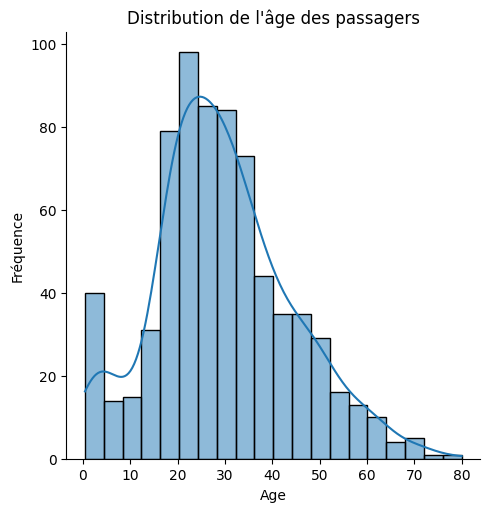

In [89]:
# Histogramme de l'âge des passagers
sns.displot(
    data=data_clean,
    x="Age",
    kde=True # courbe d'estimation
)
plt.ylabel('Fréquence')
plt.title('Distribution de l\'âge des passagers')
plt.show()

#### 1.3 Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
Notre hypothèse nulle (H<sub>0</sub>) est la suivante : L’âge moyen des passagers du Titanic est égal à 28 ans, ce qui représente l’âge moyen de la population en 1912.

**H<sub>0</sub> : μ = 28**

Notre hypothèse alternative (H<sub>1</sub>) est la suivante : L’âge moyen des passagers du Titanic n’est pas égal à 28 ans, ce qui représente l’âge moyen de la population en 1912.

**H<sub>1</sub> : μ =/= 28**

#### 1.4 Identifier le test statistique approprié selon les hypothèses énoncées

Selon nous, le test statistique approprié est le t-test pour un échantillon. Ce test nous permettra de comparer la moyenne de l’échantillon avec notre valeur donnée (28 ans) afin de savoir si elle diffère de manière significative.
Comme la variance de la population est inconnue, le z-test ne peut pas être utilisé. Le t-test, lui, est parfait dans ce contexte car il repose sur une estimation.

#### 1.5 Vérifier la validation des assomptions selon le test identifié
Concernant le t-test, les assomptions sont les suivantes :
 - L'échantillon est aléatoire
 - La taille de l'échantillon est supérieure à 30 ou la population est normalement distribuée

L'échantillon possède bien plus de 30 valeurs dans notre cas, car notre jeu de données possède la moitié des passagers du Titanic selon l'Encyclopedia Titanica.
Nous n'avons pas plus d'informations sur la sélection des passagers, mais on estime que cet échantillon est aléatoire.

Source : https://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf

#### 1.6 Calculer la statistique ainsi que la p-valeur
Selon la formule suivante nous permettant de calculer la statistique t :
$$ t = \frac{\bar{X} - \mu}{s / \sqrt{n}} $$

In [90]:
# Variables
sample_mean = np.mean(data_clean["Age"]) # la moyenne de l'échantillon
sample_std = np.std(data_clean["Age"], ddof=1) # l'écart type de la population est inconnue
mu = 28 # la moyenne de la population est supposée être 28
n = len(data_clean["Age"]) # la taille de l'échantillon

# Calcul de la statistique t
t = (sample_mean - mu)/(sample_std / np.sqrt(n))

print("La statistique t est :", t)

# Calcul de la p-valeur
p_valeur = stats.t.cdf(-abs(t), df=n-1) * 2

print("La p-valeur est :", p_valeur)

La statistique t est : 3.0233009800374053
La p-valeur est : 0.002590259537786662


#### 1.7 Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%

Le seuil est défini via la variable "alpha" (0.05).
Le calcul est fait directement entre la "p_valeur" du point précédent et "alpha" afin de rejetter ou non l'hypothèse nulle.

In [91]:
# Seuil alpha
alpha = 0.05

# Si p-valeur < alpha, on rejète l'hypothèse nulle
if p_valeur < alpha:
    print("Avec un seuil alpha", str(alpha), "on rejette l'hypothèse nulle.")
    
# Si p-valeur > alpha, on échoue à rejetter l'hypothèse nulle
else:
    print("Avec un seuil alpha", str(alpha), "on échoue à rejetter l'hypothèse nulle.")

Avec un seuil alpha 0.05 on rejette l'hypothèse nulle.


#### 1.8 Interpréter le résultat et évaluer la taille de l'effet

Le test statistique mené montre que l'âge moyen des passagers du Titanic est significativement différent de l'âge moyen de la population en 1912. 

On a obtenu une statistique t de 3.02 et une p-valeur de 0.0026, ce qui est bien en dessous du seuil de 5%. Cela signifie qu'on peut rejeter l'hypothèse nulle avec un niveau de confiance de 95%. En conclusion, on peut dire que l'âge moyen des passagers n'était pas la même que celui de la population générale à cette époque.

Par contre, il faut aussi réfléchir à l'importance de cette différence dans la vraie vie, c'est pourquoi on cherche à connaître la taille de l'effet. 

Comme nous avons utilisé un t-test, on utilise le calcul de Cohen's d qui mesure l'ampleur de la différence entre deux moyennes en termes d'écarts-types:
$$ d = \frac{\bar{X} - \mu}{s} $$

Ce calcul permet de savoir si cette différence est petite, moyenne ou grande:
* si < 0.2 : la différence n'a pas de grande importance pratique
* entre 0.2 et 0.8 : la différence a un impact moyen
*  si > 0.8 : la différence a un vrai impact

Voici le calcul mené :

In [92]:
# Variables
small = 0.2 # faible différence selon Cohen's
high = 0.8 # grande différence selon Cohen's

# Calcul de Cohen's
d = (sample_mean - mu)/sample_std

# Différence
if d < small:
    print("Avec une taille de l'effet à", str(d), "on considère l'effet comme faible.")
elif d > high:
    print("Avec une taille de l'effet à", str(d), "on considère l'effet comme importante.")
else:
    print("Avec une taille de l'effet à", str(d), "on considère l'effet comme moyenne.")

Avec une taille de l'effet à 0.11330299449551398 on considère l'effet comme faible.


L'analyse montre que, même si la différence entre l'âge moyen des passagers du Titanic et celui de la population en 1912 est statistiquement significative, la taille de l'effet est faible. Cela signifie que, dans la pratique, cette différence n'a probablement pas de grande importance ou d'impact réel.

Cela s'explique par l'échantillon très grand où de petites différences peuvent devenir significatives, car il y a beaucoup de données pour détecter des variations, mais cela ne garantit pas un réel impact.
En effet, si on tient compte de la quantité de données, on se rend compte que la population est très diversifiée dans le Titanic, répartie en trois classes distinctes:
* **Première classe**: composée principalement de passagers fortunés, souvent plus âgés
* **Deuxième classe**: la classe moyenne était d'une moyenne d'âge intermédiaire
* **Troisième classe**: principalement des familles et des jeunes

Par conséquent, oui il y a une différence, mais trop petite dans la réalité.

### Q2: La survie dépend-elle de la classe du passager ?

#### 2.1 Identifier la ou les variables d’intérêt et spécifier le type
Les variables d'intérêts sont les suivantes : 
 - **Survived** : variable qui nous indique si la personne a survécu ou non (0 = morte, 1 = survécu)
 - **Pclass** : variable qui nous indique la classe de la personne (1 = Première classe, 2 = Deuxième classe, 3 = Troisième classe)

Type des variables :
 - **Survived** : qualitative binaire
 - **Pclass** : qualitative ordinale (trois valeurs différentes pouvant être hierarchisées)


#### 2.2 Réaliser une visualisation appropriée selon la ou les variables
Pour cette question, nous avons décidé d'utiliser un diagramme à barres groupées (grouped bar chart). Ce dernier est très efficace lors de la relation entre deux variables qualitatives. Cela nous permet d'avoir trois groupes de barres (les classes) qui contiennent chaucun 2 barres (les personnes qui ont survécu ou non).

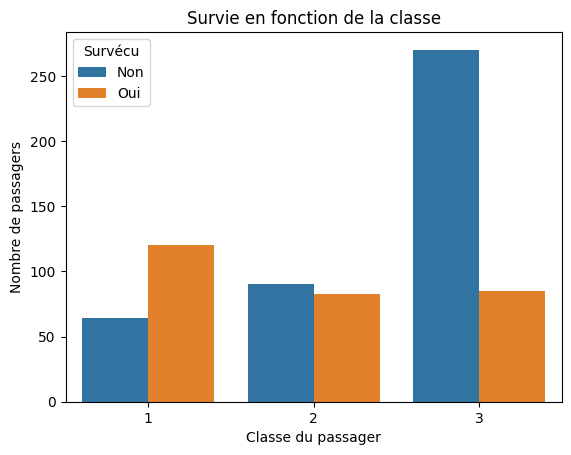

In [93]:
# Grouped bar chart de la survie en fonction de la classe
sns.countplot(data=data_clean, x='Pclass', hue='Survived')
plt.title('Survie en fonction de la classe')
plt.xlabel('Classe du passager')
plt.ylabel('Nombre de passagers')
plt.legend(title='Survécu', labels=['Non', 'Oui'])
plt.show()

#### 2.3 Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
Notre hypothèse nulle (H<sub>0</sub>) est la suivante : La survie est indépendante de la classe du passager.

**H<sub>0</sub> : P(Survived ∩ Pclass) = P(Survived) x P(Pclass)**

Notre hypothèse alternative (H<sub>1</sub>) est la suivante : La survie dépend de la classe du passager.

**H<sub>1</sub> : P(Survived ∩ Pclass) =/= P(Survived) x P(Pclass)**

#### 2.4 Identifier le test statistique approprié selon les hypothèses énoncées
Dans cette situation, le test du Chi-carré d’indépendance (Chi-Square independence test) est le plus approprié, car il permet de déterminer si des variables catégoriques sont indépendentes les unes des autres.

#### 2.5 Vérifier la validation des assomptions selon le test identifié
Concernant le test sélectionné, nous devons vérifier deux assomptions : 
- Les échantillons sont aléatoires
- Pour chaque combinaison des niveaux des variables, nous avons besoin d’au moins 5 valeurs

Comme pour la question précédente, nous allons partir sur le principe que les échantillons sont aléatoires. Le code ci-dessous nous valide le deuxième point.

In [94]:
# Tableau de contingence
contingency_table = pd.crosstab(data_clean['Pclass'], data_clean['Survived'])

# Effectifs théoriques dans chaque cellule du tableau
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print("Effectifs théoriques dans chaque cellule du tableau :")
print(expected)

Effectifs théoriques dans chaque cellule du tableau :
[[109.57303371  74.42696629]
 [103.02247191  69.97752809]
 [211.40449438 143.59550562]]


#### 2.6 Calculer la statistique ainsi que la p-valeur
Selon la formule suivante nous permettant de calculer la statistique :
$$ \chi^2 = \sum \frac{(O - E)^2}{E} $$

In [95]:
# Test du Chi-carré
chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table)

print("La statistique est :", chi2_stat)
print("La p-valeur est :", p_val)
print("Degrés de liberté :", dof)

La statistique est : 91.08074548791019
La p-valeur est : 1.6675060315554636e-20
Degrés de liberté : 2


#### 2.7 Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%

Le seuil est défini via la variable "alpha" (0.05).
Le calcul est fait directement entre la "p_valeur" du point précédent et "alpha" afin de rejetter ou non l'hypothèse nulle.

In [96]:
# Seuil alpha
alpha = 0.05

# Si p-valeur < alpha, on rejète l'hypothèse nulle
if p_valeur < alpha:
    print("Avec un seuil alpha", str(alpha), "on rejette l'hypothèse nulle.")
    
# Si p-valeur > alpha, on ne rejète pas l'hypothèse nulle
else:
    print("Avec un seuil alpha", str(alpha), "on ne rejette pas l'hypothèse nulle.")

Avec un seuil alpha 0.05 on rejette l'hypothèse nulle.


#### 2.8 Interpréter le résultat et évaluer la taille de l'effet

Le résultats démontrent une forte association entre la classe du passager et sa probabilité de survie. 

En plus de la significativité statistique, la taille de l'effet est importante pour comprendre l'ampleur de cette dépendance entre la classe et la survie. Pour calculer cela, on utilise le V de Cramer, c'est une mesure de la force de l'association entre les variables qui convient mieux au test du Chi-carré :
$$ V = \sqrt{\frac{\chi^2}{n \cdot \min(k-1, r-1)}} $$

Un V de Cramer proche de 0 indique une faible relation ainsi qu'un V proche de 1 indique une forte relation.

In [97]:
# Variables
n = contingency_table.sum().sum()  # Taille de l'échantillon
k = contingency_table.shape[0]  # Nombre de catégories de la variable Pclass (3 classes)
r = contingency_table.shape[1]  # Nombre de catégories de la variable Survived (2 valeurs : Oui/Non)

# Calcul du V de Cramer
v_cramer = np.sqrt(chi2_stat / (n * min(k - 1, r - 1)))

# Interprétation
if v_cramer < 0.1:
    print("Avec un V de Cramer à", str(v_cramer), "on considère la relation comme faible.")
elif v_cramer > 0.3:    
    print("Avec un V de Cramer à", str(v_cramer), "on considère la relation comme importante.")
else:    
    print("Avec un V de Cramer à", str(v_cramer), "on considère la relation comme modérée.")

Avec un V de Cramer à 0.35766240415815087 on considère la relation comme importante.


Ce calcul démontre que non seulement la classe du passager a une influence statistiquement significative sur la survie, mais que l'impact de cette variable est important dans le contexte réel.

Dans le contexte historique, ça s'explique par la **priorité donnée aux passagers de première classe** qui ont eu un accès prioritaire aux canots de sauvetage, en raison de leur statut social et de leur influence. Une autre raison est que les passagers de troisième classe étaient logés dans des sections du navire plus difficiles d'accès, ils n'ont pas eu d'accès rapide aux canots de sauvetage. 

### Q3: Existe-t-il une différence d'âge entre les passagers qui ont survécu et les passagers décédés ?

#### 3.1 Identifier la ou les variables d’intérêt et spécifier le type
Les variables d'intérêts sont les suivantes : 
 - **Age** : variable qui nous indique l'âge de chaque passager
 - **Survived** : variable qui nous indique si la personne a survécu ou non (0 = morte, 1 = survécu)

Type des variables :
 - **Age** : quantitative continue
 - **Survived** : qualitative binaire

#### 3.2 Réaliser une visualisation appropriée selon la ou les variables
Pour cette question, nous avons sélectionné un diagramme "boxplot", car ce dernier est recommandé lorsqu'il y a une relation entre une variable qualitative et une variable quantitative.

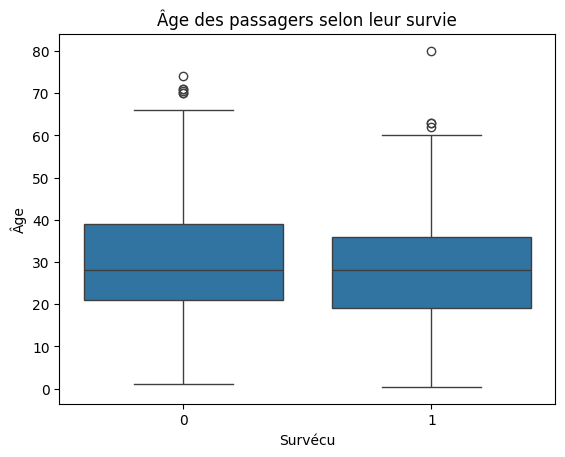

In [98]:
# Boxplot de l'âge des passagers selon leur survie
sns.boxplot(data=data_clean, x='Survived', y='Age')
plt.title('Âge des passagers selon leur survie')
plt.xlabel('Survécu')
plt.ylabel('Âge')
plt.show()

#### 3.3 Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
Notre hypothèse nulle (H<sub>0</sub>) est la suivante : L’âge moyen des passagers survivants est égal à l’âge moyen des passagers décédés.

**H<sub>0</sub> : μ<sub>Survécu</sub> =  μ<sub>Décédé</sub>**

Notre hypothèse alternative (H<sub>1</sub>) est la suivante : L’âge moyen des passagers survivants est différent de l’âge moyen des passagers décédés.

**H<sub>1</sub> : μ<sub>Survécu</sub> =/=  μ<sub>Décédé</sub>**

#### 3.4 Identifier le test statistique approprié selon les hypothèses énoncées
Selon nous, le test approprié est le t-test à deux échantillons (two-sample t-test), car ce dernier nous permet de comparer deux moyennes d'une population. Généralement cette population est inconnue, bien qu'elle soit connue dans notre exercice, ce test devrait tout de même fonctionner.

#### 3.5 Vérifier la validation des assomptions selon le test identifié
Les assomptions à vérifier sont les suivantes :
 - Les échantillons sont aléatoires.
 - Les échantillons sont indépendants les uns des autres.
 - La taille des échantillons est supérieure à 30, ou les populations sont normalement distribuées.

Comme pour les questions précédentes, la taille de l'échantillon est supérieure à 30 et nous allons partir sur le principe que les échantillons sont aléatoires.

#### 3.6 Calculer la statistique ainsi que la p-valeur
Selon la formule suivante pour calculer la statistique t pour 2 échantillons :
$$ t = \frac{(\bar{X_1} - \bar{X_2}) - (\mu_1 - \mu_2)}{\sqrt{\frac{s_{1}^2}{n_1} + \frac{s_{2}^2}{n_2}}} $$

In [100]:
# Calcul de la statistique t et la p-valeur
t, p_valeur = stats.ttest_ind(
    group_survived,
    group_died,
    alternative="two-sided",
    equal_var=False
)

print("La statistique t est de : " + str(t))
print("La p-valeur associée est de : " + str(p_valeur))

NameError: name 'group_survived' is not defined

#### 3.7 Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%

Le seuil est défini via la variable "alpha" (0.05).
Le calcul est fait directement entre la "p_valeur" du point précédent et "alpha" afin de rejetter ou non l'hypothèse nulle.

In [34]:
# Si p-valeur < alpha, on rejète l'hypothèse nulle
if p_valeur < alpha:
    print("Avec un seuil alpha", str(alpha), "on rejète l'hypothèse nulle.")
    
# Si p-valeur > alpha, on ne rejète pas l'hypothèse nulle
else:
    print("Avec un seuil alpha", str(alpha), "on ne rejète pas l'hypothèse nulle.")

Avec un seuil alpha 0.05 on rejète l'hypothèse nulle.


#### 3.8 Interpréter le résultat et évaluer la taille de l'effet

Pour évaluer la taille de l'effet pour deux échantillons indépendants, on utilise Cohen's d, voici sa formule :

$$ d = \frac{M_1 - M_2}{\text{SD}_{\text{pooled}}}$$

In [35]:
# Moyennes et écarts-types
mean_survived = np.mean(group_survived)
std_survived = np.std(group_survived, ddof=1)
mean_died = np.mean(group_died)
std_died = np.std(group_died, ddof=1)

# Tailles des échantillons
n_survived = len(group_survived)
n_died = len(group_died)

# Calcul de l'écart-type combiné (SD pooled)
sd_pooled = np.sqrt(((n_survived - 1) * std_survived**2 + (n_died - 1) * std_died**2) / (n_survived + n_died - 2))

# Calcul de Cohen's d
cohens_d = (mean_survived - mean_died) / sd_pooled

# Résultats
print(f"Moyenne des survivants : {mean_survived:.2f}")
print(f"Moyenne des décédés : {mean_died:.2f}")
print(f"Écart-type combiné : {sd_pooled:.2f}")
print(f"Taille de l'effet (Cohen's d) : {cohens_d:.3f}")

Moyenne des survivants : 28.19
Moyenne des décédés : 30.63
Écart-type combiné : 14.45
Taille de l'effet (Cohen's d) : -0.168


Selon les seuils d'interprétation proposés par Cohen, une taille de l'effet à -0.168 est négligeable. Donc bien que statistiquement significative avec une hypothèse nulle rejetée, la différence d'âge est si petite, qu'elle n'a pas de signification pratique importante.

Cela pourrait s'expliquer par la moyenne d'âge de la première classe étant plus élevée, ils ont embarqué en priorité, ainsi les résultat sont biaisés étant équilibrés par des âges très élevés et très faibles à la fois, qui nous donnerait cette taille de l'effet négligeable.

On va alors réprésenter ces données autrement, par tranches d'âge, sur un histogramme empilé:

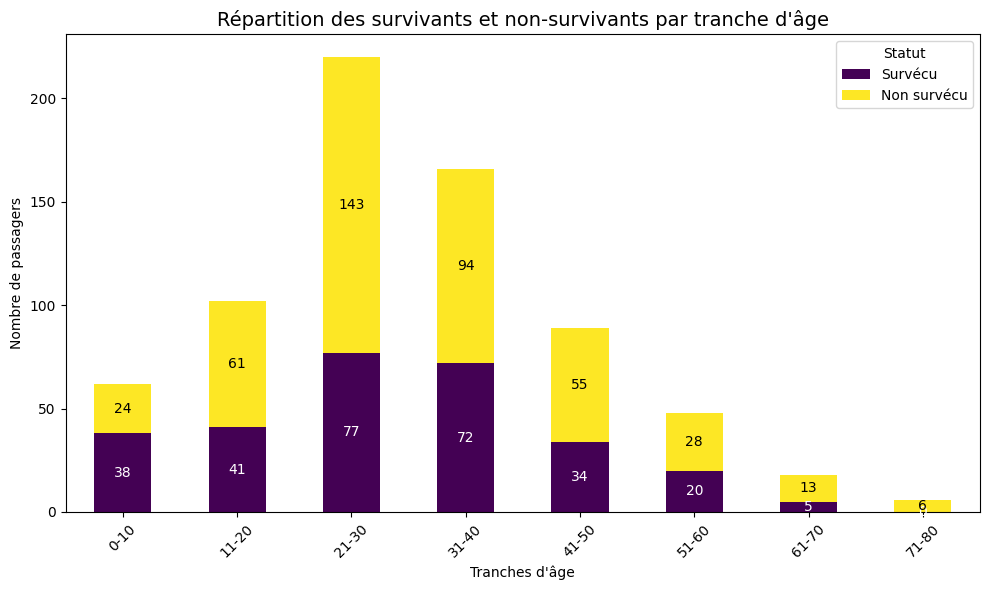

In [84]:
# Création de tranches d'âge
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']
data_clean['AgeGroup'] = pd.cut(data_clean['Age'], bins=bins, labels=labels, right=False)

# Calcul des données

age_counts = data_clean.groupby('AgeGroup', observed=False)['Survived'].count() # Total par tranche
age_survivors = data_clean.groupby('AgeGroup', observed=False)['Survived'].sum()  # Survivants par tranche
age_non_survivors = age_counts - age_survivors  # Non-survivants par tranche

# Préparation des données pour le diagramme empilé
stacked_data = pd.DataFrame({
    'Survécu': age_survivors,
    'Non survécu': age_non_survivors
}, index=labels)

# Visualisation
stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Ajout des annotations
for i, (survived, total) in enumerate(zip(age_survivors, age_counts)):
    plt.text(i, survived / 2, f'{int(survived)}', ha='center', va='center', color='white', fontsize=10)
    plt.text(i, survived + (total - survived) / 2, f'{int(total - survived)}', ha='center', va='center', color='black', fontsize=10)

# Ajustement des labels et du titre
plt.title('Répartition des survivants et non-survivants par tranche d\'âge', fontsize=14)
plt.xlabel('Tranches d\'âge')
plt.ylabel('Nombre de passagers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Statut')
plt.show()


Cette nouvelle représentation est plus convainquante, car en effet, on constate sur l'histogramme empilé que la tranche d'âge qui a proportionnellement le mieux survécu est celle des enfants, il y a plus d'enfants entre 0 et 10 ans qui ont survécu que ceux qui en sont décédés. Cela s'explique par la consigne de sauvetage à bord du Titanic "Women and children first" qui faisait embarquer les femmes et les enfants en priorité aux canots de sauvetage.

On constate d'autres choses intéréssantes sur cet histogramme empilé, comme par exemple que la tranche d'âge qui a connu le plus de décès, est aussi celle qui a le mieux survécu en valeur absolue.

Cependant, notre taille de l'effet étant négligeable, on comprend que malgré les consignes, des personnes plus âgées ont embarqué avant que tous les enfants n'aient terminés d'être placés sur les canots. Cette politique n'a pas toujours été appliquée, car la première classe dont la moyenne d'âge est plus élevée, était plus proche des canots de sauvetage, ils ont pu être sauvés plus facilement, contrairement à la deuxième ou troisième classe qui elle, était largement composée de familles ou de jeunes. Cela est observable par exemple avec la tranche d'âge entre 51 et 60 ans qui ont proportionnellement bien survécu en comparaison avec la tranche des 21-30.

### Q4: Existe-t-il une relation entre l'âge des passagers et le prix des billets ?

#### 4.1 Identifier la ou les variables d’intérêt et spécifier le type
Les variables d'intérêts sont les suivantes : 
 - **Age** : variable qui indique l'âge de chaque passager
 - **Fare** : variable qui indique le prix du billet par passager (c'est le prix total pour une famille / divisé par la taille de la famille)

Type des variables :
 - **Age** : quantitative continue
 - **Fare** : quantitative continue

#### 4.2 Réaliser une visualisation appropriée selon la ou les variables
Pour une relation entre deux variables quantitatives, nous avons décidé d'utiliser un nuage de points (scatter plot).

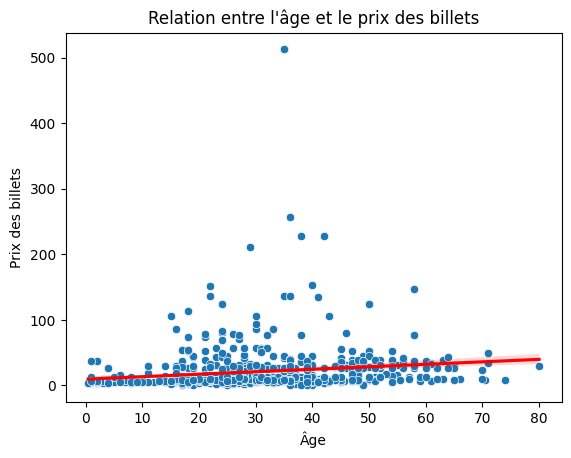

In [36]:
# Scatter plot de l'âge et du prix des billets
sns.scatterplot(data=data_clean, x='Age', y='Fare')
sns.regplot(data=data_clean, x='Age', y='Fare', scatter=False, color='red')  # Ligne de régression afin de visualiser la tendance
plt.title("Relation entre l'âge et le prix des billets")
plt.xlabel("Âge")
plt.ylabel("Prix des billets")
plt.show()

#### 4.3 Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
Notre hypothèse nulle (H<sub>0</sub>) est la suivante : Il n’existe pas de relation significative entre l’âge des passagers et le prix des billets.

**H<sub>0</sub> : ρ = 0**

Notre hypothèse alternative (H<sub>1</sub>) est la suivante : Il existe une relation significative entre l’âge des passagers et le prix des billets.

**H<sub>1</sub> : ρ =/= 0**

*ρ = coefficient de corrélation de Pearson, il examine la relation entre deux variables et détermine l'influence de l'une sur l'autre.*

#### 4.4 Identifier le test statistique approprié selon les hypothèses énoncées
Afin d'analyser une relation entre deux variables quantitatives continues, nous nous sommes penchés sur le test de coefficient de corrélation (Pearson). Ce dernier nous permettra d'identifier si les variables sont liées linéairement, ainsi que les évnetuelles nature et force de cette relation.

 - Relation linéaire faible: ±0.1 – ±0.3
 - Relation linéaire moyenne: ±0.3 – ±0.6
 - Relation linéaire forte: ±0.6 – ±1.0

#### 4.5 Vérifier la validation des assomptions selon le test identifié
Afin d'effectuer le test mentionné, nous devont valider les assomptions suivantes :
 - Les 2 variables doivent être quantitatives et doivent obtenues à partir d’un échantillon aléatoire
 - Le scatter plot doit montrer que les données sont approximativement liées linéairement
 - Les résidus de la régression linéaire sont indépendants
 - Les résidus de la régression linéaire sont distribués selon une loi normale de moyenne 0
 - Les résidus de la régression linéaire sont distribués de façon homogène (homoscedasticité)

Pour le premier point, nous avons effectivement deux variables quantitatives et l'échantillon est considéré aléatoire.

Sur la visualisation ci-dessus (Scatter plot), il est très difficile d'affirmer que les données sont liées linéairement. Certaines données ne sont pas placées proches de notre ligne de régression, ce qui indique clairement que ces variables ne sont pas liées linéairement. Pour l'exercice, nous allons tout de même continuer les recherches.

Il nous semble inutile de parler des autres assomptions, sachant que la deuxième n'est pas acceptée.

#### 4.6 Calculer la statistique ainsi que la p-valeur
Il est possible de calculer ce coefficient de corrélation via la fonction **"pearsonr"** de **"scipy.stats"**. Nous allons retrouver la nature et la force de la relation via le coefficient de corrélation, ainsi que la p-valeur associée.

In [37]:
# Calcul du coefficient de corrélation de Pearson et de la p-valeur
corr_coeff, p_value = stats.pearsonr(data_clean['Age'], data_clean['Fare'])

print("Coefficient de corrélation (Pearson) : " + str(corr_coeff))
print("La p-valeur associée est de : " + str(p_value))

Coefficient de corrélation (Pearson) : 0.1456331592305597
La p-valeur associée est de : 9.62085909106819e-05


#### 4.7 Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%

Le seuil est défini via la variable "alpha" (0.05).
Le calcul est fait directement entre la "p_valeur" du point précédent et "alpha" afin de rejetter ou non l'hypothèse nulle.

In [38]:
# Seuil alpha
alpha = 0.05

# Si p-valeur < alpha, on rejète l'hypothèse nulle
if p_valeur < alpha:
    print("Avec un seuil alpha", str(alpha), "on rejète l'hypothèse nulle.")
    
# Si p-valeur > alpha, on ne rejète pas l'hypothèse nulle
else:
    print("Avec un seuil alpha", str(alpha), "on ne rejète pas l'hypothèse nulle.")

Avec un seuil alpha 0.05 on rejète l'hypothèse nulle.


Selon la p-valeur identifiée, l'hypothède nulle est rejetée. Cependant, comme le démontre le point 4.5, certaines assomptions ne sont pas respectées et ces chiffres ne peuvent pas être pris en compte pour le rejet ou non de nos hypothèses.

#### 4.8 Interpréter le résultat et évaluer la taille de l'effet

Comme on compare deux variables quantitatives continues, le coefficient de corrélation de Pearson est un outil adapté pour évaluer la relation entre l'âge des passagers et le prix des billets:

$$ r = \frac{Σ((xi - x̄) (yi - ȳ))} {√(Σ(xi - x̄)² * Σ(yi - ȳ)²)} $$

La taille de l'effet se mesure ici à partir du coefficient de détermination r².


In [39]:
# Coefficient de détermination
r_squared = corr_coeff**2

print("Le coefficient de détermination est de : " + str(r_squared))

Le coefficient de détermination est de : 0.021209017067473555


La variance dans le prix des billets peut être seulement expliquée à 2.12% par l'âge.

Sur le Titanic, les prix des billets étaient déterminés par des factures multiples :
* Classe sociale : Les passagers de 1ère payaient beaucoup plus cher que ceux des classes inférieures.
* Cabines familiales : Les familles avec enfants ou les groupes payaient souvent des tarifs collectifs.
* Urgence des réservations : Les passagers ayant réservé à la dernière minute ont parfois payé plus cher.

En effet, l'âge n'était pas un facteur direct de tarification.

Pour chacune des questions 1 à 4 ci-dessus, argumenter de manière statistique en effectuant chacune des étapes suivantes:
1. Identifier la ou les variables d'intérêt et spécifier le type.
2. Réaliser une visualisation appropriée selon la ou les variables.
3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
4. Identifier le test statistique approprié selon les hypothèses énoncées.
5. Vérifier la validation des assumptions selon le test identifié.
6. Calculer la statistique ainsi que la p-valeur.
7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.
8. Interpréter le résultat et évaluer la taille de l'effet.

Quelques liens utiles pour la taille de l'effet:
* [https://rpsychologist.com/cohend/](https://rpsychologist.com/cohend/)
* [https://datatab.net/tutorial/effect-size-independent-t-test](https://datatab.net/tutorial/effect-size-independent-t-test)
* [https://www.simplypsychology.org/effect-size.html](https://www.simplypsychology.org/effect-size.html)

## 3. Data mining (2 pts)

### Q1: Effectuer une analyse statistique à l'aide de la régression logistique avec comme variable dépendente la variable `Survived`. Interpréter les coefficients et discuter de leur importance statistique en vous appuyant sur leur p-valeur.

Comme cité dans la consigne, notre variable dépendante Y est **Survived** (0 = mort, 1 = survécu).

Pour les variables indépendantes X, nous allons sélectionner le reste des données (sauf la survie qui est notre variable dépendante Y). Il serait également possible de ne prendre que certaines valeurs.

In [29]:
x = data_clean.drop(columns=["Survived"])
y = data_clean["Survived"]

Une fois nos variables définies, nous allons utiliser la bibliothèque **statsmodel** qui nous permet de réaliser une régression logistique.

In [31]:
# Trasformation des booléens en entiers
x["Sex_male"] = x["Sex_male"].astype(int)
x["Embarked_Q"] = x["Embarked_Q"].astype(int)
x["Embarked_S"] = x["Embarked_S"].astype(int)

# Générer un modèle de régression logistique
model = sm.Logit(
    y,
    sm.add_constant(x)
)

# Fit le modèle
model_fit = model.fit()

# Résumé du modèle
print(model_fit.summary())

Optimization terminated successfully.
         Current function value: 0.445519
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Mon, 13 Jan 2025   Pseudo R-squ.:                  0.3398
Time:                        18:16:41   Log-Likelihood:                -317.21
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 1.324e-66
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7251      0.659      8.691      0.000       4.434       7.016
Pclass        -1.1795      0.

In [ ]:
# Récupération des coefficients
coefs = model_fit.params

print("Coefficients : " + str(coefs.tolist()))

In [ ]:
sns.scatterplot(
    x="Age",
    y="Sex_male",
    data=data_clean,
    hue="Survived"
)

# Calcul de l'intercept et des coefficients
intercept = coefs["const"]
coef_age = coefs["Age"]
coef_sex = coefs["Sex_male"]

# Calcul de deux points (au hasard) pour tracer la droite
age_range = (-coefs[0] - coefs[5]*data.iloc[0,1])/coefs[2]
sex_values = (-coefs[0] - coefs[2]*data.iloc[1,1])/coefs[5]
plt.axline((age_range, data.iloc[0,1]), (sex_values, data.iloc[1,1]), color = "green")
plt.ylim(-0.2, 1.2)

# Titres et affichage
plt.title("Scatter plot avec droite de décision")
plt.xlabel("Age")
plt.ylabel("Sexe (0 = femme, 1 = homme)")
plt.show()

In [ ]:
# Calcul du odds ratio
odds_ratio = np.exp(coefs)

pd.DataFrame(odds_ratio, columns=["Odds ratio"])

Dans cet exercice, nous avons utilisé la régression logistique afin de prédire si un passager va survivre ou non, selon les caractéristiques des passagers (l'âge et le sexe sur notre schéma).

### Q2: Effecter une analyse statistique à l'aide d'un arbre de classification avec comme variable dépendente la variable `Survived` et une profondeur maximale de 4. Visualiser l'arbre et expliquer quelques décisions.

**Conclusion: Interpréter les résultats des deux analyses statistiques et résumer les points importants de votre étude.**